# Feature Engineering
The main problem in this data set is that there are too many features, 26 agro-climatic indicators, with high collinearity. To deal with this problem the following steps will be applied in this part:
* Using domain knowledge only some of the most important columns will be selected as predictor variables. 
* Only a one of the variables will be kept in a Highly correlated pair.
* Power transformation sometimes help reduce collinearity, which will be applied here. 
  

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import norm, skew #for some statistics
from scipy import stats

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.tsatools import detrend

In [10]:
# Columns don't need transformed
columns_to_copy = ['County_ID','time',
                     'County', 'ILLINOIS',
       'INDIANA', 'IOWA', 'KANSAS', 'MICHIGAN', 'MINNESOTA', 'NEBRASKA',
       'NORTH DAKOTA', 'OHIO', 'SOUTH DAKOTA', 'WISCONSIN']
# Function for reshaping data after power transformation
def reshape_after_pt(df_pt, df): 
    df_pt = pd.DataFrame(df_pt, columns=
                             df.select_dtypes(include=['float64']).
                         drop(['County_ID'], axis=1).columns)
    df_pt.index = df.index
    
    for column in columns_to_copy:
        df_pt[column] = df[column]
    
    return df_pt

In [11]:
# Read the all variables data from the data wrangling steps
df = pd.read_pickle('../Data/all_variables.pkl')
soy_counties = list(df['County_ID'].unique())

#### Splitting data to train and test
The rest of the parts require carefully separating train and validation data. Otherwise significant data leakage could occur. Train and test splitting will be done by manually without using builtin sklearn or other packages because of the panel structure of the data.

In [12]:
# Creat a function to split data for train and test and get dummies for counties
def panel_data_split(df,y_column, test_size, one_hot_encoding=True):
    # Collect features and response columns from each county group in a list
    train_collect = []
    test_collect = []
    # loop over the soy_counties and split train and test for each county
    for county in soy_counties:
        # Select the county rows
        df_county = df.query('County_ID == @county').copy()
        # split train and test for the county
        df_county_train = df_county[:-test_size]
        df_county_test = df_county[-test_size:]
        # append the train, test dataframe for the county in a list
        train_collect.append(df_county_train)
        test_collect.append(df_county_test)
    # concat the county train, test splits on axis=0
    df_train = pd.concat(train_collect, axis=0)
    df_test = pd.concat(test_collect, axis=0)
    # get dummies for states. Counties will be treated as observations for states
    if one_hot_encoding == True:
        df_train = pd.get_dummies(df_train, columns=['State'], prefix="", 
                                  prefix_sep="", drop_first=True)
        df_test = pd.get_dummies(df_test, columns=['State'], prefix="", 
                                  prefix_sep="", drop_first=True)
    # Split the features and response columns
    X_train = df_train.drop(y_column, axis=1).reset_index(drop=True)
    y_train = df_train[y_column].reset_index(drop=True)
    X_test = df_test.drop(y_column, axis=1).reset_index(drop=True)
    y_test = df_test[y_column].reset_index(drop=True)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = panel_data_split(df, y_column='Yield',test_size=10, one_hot_encoding=True)
df_train_all = pd.concat([X_train, y_train], axis=1)
df_test_all = pd.concat([X_test, y_test], axis=1)

Let's check the correlation matrix to decide which variables to conider for modelling. Note that only the train data is analysed in order not to cause data leakage for reliable validation.

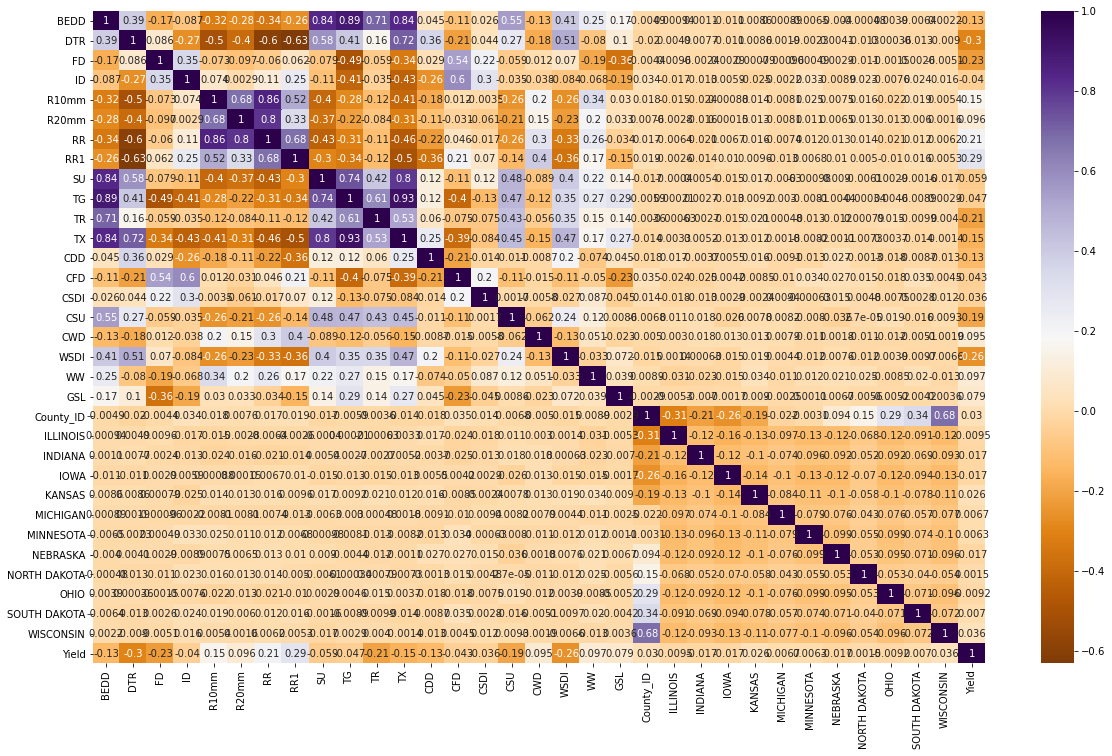

In [13]:
# let's plot pairwise correlation heatmap
f, ax = plt.subplots(figsize=(20, 12))
ax = sns.heatmap(df_train_all.corr(), annot=True, cmap='PuOr')
plt.show()

Let's recall what these variables
<a id='clim_ind_names'></a>

Let's drop some highly collinear variables, and some based on domain knowledge. For instance heavy and very heavy precipitation (R10mm & R20mm) could provide information on crop damage and run off loss. However, in this data it seems like both have a positive effect on crop yield. This is probably because of the annual aggregation ( actually growing season aggregation at each year) and spatial averaging over a large area which tends to mask the actual effect of the local events such as this. Furthermore, all the rain variables are strongly correlated to each other, this means when number of R20mm events is high at a certain year, RR1mm is very likely high too which is one of the key factor for higher yield. The other variables are dropped based on similar fashion.

In [14]:
vars_to_drop = ["BEDD", "DTR", "ID", "R20mm", "RR", "SU", "TX"]
df_train = df_train_all.copy()
df_test = df_test_all.copy()
for var in df_train_all:
    if var in vars_to_drop:
        df_train = df_train.drop(var, axis=1)
        df_test = df_test.drop(var, axis=1)
df_train.head()

,time,FD,R10mm,RR1,TG,TR,CDD,CFD,CSDI,CSU,...,IOWA,KANSAS,MICHIGAN,MINNESOTA,NEBRASKA,NORTH DAKOTA,OHIO,SOUTH DAKOTA,WISCONSIN,Yield
0,1981-01-01,-1.677419,5.122581,-3.019354,-0.212136,0.619355,-1.010754,-0.251613,-1.488172,0.907527,...,0,0,0,0,0,0,0,0,0,4.089032
1,1982-01-01,3.396885,-1.837598,8.616465,-0.302943,-0.844049,-1.322656,1.765740,-1.463701,1.336893,...,0,0,0,0,0,0,0,0,0,2.390968
2,1983-01-01,-1.528810,-3.797776,-8.747719,0.227405,2.692547,6.365442,-1.216908,-1.439229,1.766259,...,0,0,0,0,0,0,0,0,0,-1.307097
3,1984-01-01,2.545495,10.242046,17.888100,-0.445678,0.229144,0.053540,1.800445,-1.414757,2.195625,...,0,0,0,0,0,0,0,0,0,-0.005161
4,1985-01-01,-4.380200,-6.718132,-9.476084,0.664748,-0.234261,2.741638,-2.182202,-1.390286,2.624990,...,0,0,0,0,0,0,0,0,0,1.296774


In [15]:
# Let's see how strong the colinearity in overall data
np.linalg.det(df_train.corr())

4.802831036487298e-08

The determinant of entire correlation matrix can be used as a proxy for how strong colinearity in the data. The closer the determinant to 1 is better (less colinearity). We have got a result indicating there is still some colinearity in the data. 

#### Checking Normality of the Variables.
Regression models assume that the variables are normally distributed. Therefore the following steps will be applied to check for distribution of the variables and transform those with high skeweness and kurtosis distributions:
* Do skewness test for each columns.
* Consider those with absolute value of skewness > 0.5 as skewed the rest as acceptable
* Apply box-cox transformation 

In [16]:
# Skewness test
skewed = df_train.select_dtypes(include=['float64']).drop(['County_ID'], axis=1).skew().sort_values(ascending=False)
pd.DataFrame({'skewness': skewed})

,skewness
CSDI,2.577010
WSDI,2.428766
CDD,1.982677
CWD,1.554561
CFD,1.067286
WW,0.466946
CSU,0.449129
GSL,0.407100
TR,0.243263
R10mm,0.171685


Several variables are skewed. We can fix the skewness by applying power transformation to variables including the response variable. 

In [17]:
# Apply yeo-johnson power transformation which is unlike box-cox method allows negative values
pt = PowerTransformer(method='yeo-johnson', standardize=True)
df_train_pt = pt.fit_transform(df_train.select_dtypes(include=['float64']).drop(['County_ID'], axis=1))
df_train_pt = reshape_after_pt(df_train_pt, df_train)
pd.DataFrame(df_train_pt.select_dtypes(include=['float64']).
             drop(['County_ID'], axis=1).skew().
             sort_values(ascending=False), 
             columns=['skewness'])

,skewness
GSL,0.131588
Yield,0.034267
RR1,0.030242
R10mm,0.024051
TG,0.001141
FD,0.000269
WW,-0.003701
CSU,-0.014370
CWD,-0.051314
CDD,-0.061812


In [18]:
# Apply yeo-johnson power transformation whcih is unlike box-cox method allows negative values
df_test_pt = pt.transform(df_test.select_dtypes(include=['float64']).drop(['County_ID'], axis=1))
df_test_pt = reshape_after_pt(df_test_pt, df_test)
pd.DataFrame(df_test_pt.select_dtypes(include=['float64']).
             drop(['County_ID'], axis=1).skew().
             sort_values(ascending=False), 
             columns=['skewness'])

,skewness
CSDI,1.284504
FD,0.834288
TG,0.500100
WW,0.487156
RR1,0.246624
R10mm,0.244317
Yield,-0.014604
TR,-0.094886
CWD,-0.144357
GSL,-0.161941


Some variables are a bit skewed in the test data, but notice that the size of the test data is rather small, only 20 sample. Even if the population was exactly normal, drawing 20 sample from this population would be likely to result slighlty skewed sample distribution. The same is true for the train data which has 100 samples, but this study about the methodology. The sample data can be extended in the future by calculating the agro-climatic indicators manually from fundemental climate variables which usually have larger sample size. Once a larger sample is obtained this notebook can be used as it is to built more reliable models.

Now that all the variables are standardized and tranformed to normal distribution it is a good idea to revisit the colinearity check since pearson correlations are more reliable when the variables are normally distributed.

In [19]:
# Let's see how strong the colinearity in overall data
np.linalg.det(df_train_pt.select_dtypes(include=['float64']).drop(['County_ID'], axis=1).corr())

0.024186118145380194

The colinearity is only slightly reduced. Some more variables could be droped, but I will leave that to Lasso regression. 

Let's also transform the data with all the variables. This data will be used for Lasso regression to handle droping features.

In [20]:
# Transform the data with all the variables
pt_all = PowerTransformer(method='yeo-johnson', standardize=True)
df_train_all_pt = pt_all.fit_transform(df_train_all.select_dtypes(include=['float64']).drop(['County_ID'], axis=1))

df_train_all_pt = reshape_after_pt(df_train_all_pt, df_train_all)
pd.DataFrame(df_train_all_pt.select_dtypes(include=['float64']).
             drop(['County_ID'], axis=1).skew().
             sort_values(ascending=False), 
             columns=['skewness'])

,skewness
GSL,0.131588
RR,0.059466
TX,0.035950
Yield,0.034267
RR1,0.030242
R10mm,0.024051
SU,0.012744
R20mm,0.003203
TG,0.001141
FD,0.000269


In [21]:
# Apply yeo-johnson power transformation whcih is unlike box-cox method allows negative values
df_test_all_pt = pt_all.transform(df_test_all.select_dtypes(include=['float64']).drop(['County_ID'], axis=1))
df_test_all_pt = reshape_after_pt(df_test_all_pt, df_test_all)
pd.DataFrame(df_train_all_pt.select_dtypes(include=['float64']).
             drop(['County_ID'], axis=1).skew().
             sort_values(ascending=False), 
             columns=['skewness'])

,skewness
GSL,0.131588
RR,0.059466
TX,0.035950
Yield,0.034267
RR1,0.030242
R10mm,0.024051
SU,0.012744
R20mm,0.003203
TG,0.001141
FD,0.000269


#### Creating Categorical Yield Data 

Since the sample size is small, while there are too many features, and the actual relationship between the yield values and the agro-climatic indicators are complex regression models will fit poorly. However, a classification problem may work better with creating categorical yield loss or gain variable in reference to average yield data (zero after detrending). In modelling section I will built both regression and classification models.

Perhaps what's more interesting would be to predict significant jumps or drops in yield. However, sample size again would not be enough  for a model to learn from data because there would be even less sample with significant jumps or drops.

In [22]:
# Check if there is any 0 yield
if (df_train['Yield']==0).sum() == 0:
    print('There is no zero yield in train')
if (df_test['Yield']==0).sum() == 0:
    print('There is no zero yield in test')

There is no zero yield in train
There is no zero yield in test


In [23]:
# Create the categorical yield data for train
df_train['yield_chng'] = df_train['Yield'] > 0
df_train['yield_chng'] = df_train['yield_chng'].astype(int)
df_train['yield_chng'].value_counts()

1    5063
0    3937
Name: yield_chng, dtype: int64

In [24]:
# Create the categorical yield data for test
df_test['yield_chng'] = df_test['Yield'] > 0
df_test['yield_chng'] = df_test['yield_chng'].astype(int)
df_test['yield_chng'].value_counts()

1    2395
0    2105
Name: yield_chng, dtype: int64

In [25]:
# copy the yield_chng to transformed data
# for df in [df_pt_train, df_pt_test,
#           df_train_all_pt,df_test_all_pt]:
df_train_pt['yield_chng'] = df_train['yield_chng'].copy()
df_train_all_pt['yield_chng'] = df_train['yield_chng'].copy()
df_test_pt['yield_chng'] = df_test['yield_chng'].copy()
df_test_all_pt['yield_chng'] = df_test['yield_chng'].copy()

In [26]:
# save the final data to disk
df_train_all_pt.to_pickle('../Data/df_train_all_pt.pkl')
df_test_all_pt.to_pickle('../Data/df_test_all_pt.pkl')
df_train_pt.to_pickle('../Data/df_pt_train.pkl')
df_test_pt.to_pickle('../Data/df_pt_test.pkl')